# Proyecto de árbol de decisión

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from pickle import dump



In [2]:
diab = pd.read_csv("../data/raw/04_diabetes.csv")
diab.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
diab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
diab.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [5]:
diab = diab.drop_duplicates().reset_index(drop=True)
diab.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Análisis exploratorio de datos
### Reemplazar ceros por NaN

In [6]:
values_with_zeros_as_nan = ["Glucose",
                            "BloodPressure",
                            "SkinThickness",
                            "Insulin",
                            "BMI"]

diab[values_with_zeros_as_nan] = diab[values_with_zeros_as_nan].replace(0, np.nan)

#imputación de NaNs por la mediana
imputer = SimpleImputer(strategy="median")
diab[values_with_zeros_as_nan] = imputer.fit_transform(diab[values_with_zeros_as_nan])

diab[values_with_zeros_as_nan].isna().sum()

Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64

Las variables relacionadas con mediciones clínicas contienen valores “0” que no son fisiológicamente posibles.
Se interpretan como datos faltantes y se pueden convertir a NaN para tratarlos correctamente.

Tras convertirlos a NaN, es necesario tratarlos antes de entrenar el modelo, ya que muchos algoritmos de scikit-learn (incluyendo DecisionTreeClassifier) no aceptan valores nulos.

Se emplea imputación mediante la mediana, una técnica adecuada en este caso por tres motivos:

* Es robusta frente a outliers, que son frecuentes en este dataset.

* Mantiene la distribución original sin introducir sesgos extremos.

* Es un método sencillo y apropiado para el tipo de modelo a utilizar.

En un principio se deja el código comentado ya que distorsiona los gráficos, luego se comprobarán las métricas.

#### Distribución de la variable objetivo

En este dataset nuestro target es el resultado de si se tiene o no diabetes, así que vamos a ver su distribución

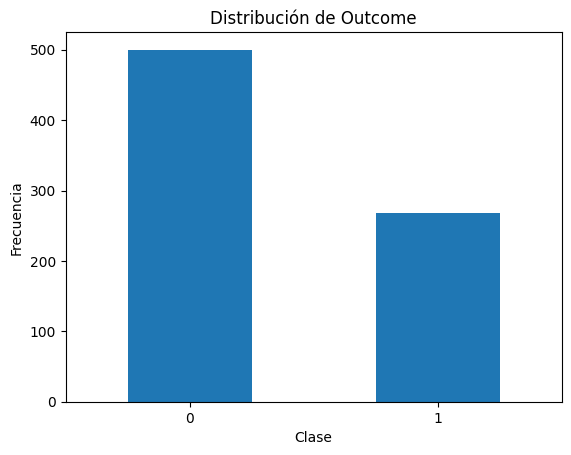

In [7]:
diab["Outcome"].value_counts().plot(kind="bar")

plt.title("Distribución de Outcome")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")

plt.xticks(rotation=0)

plt.show()

### Valores atípicos

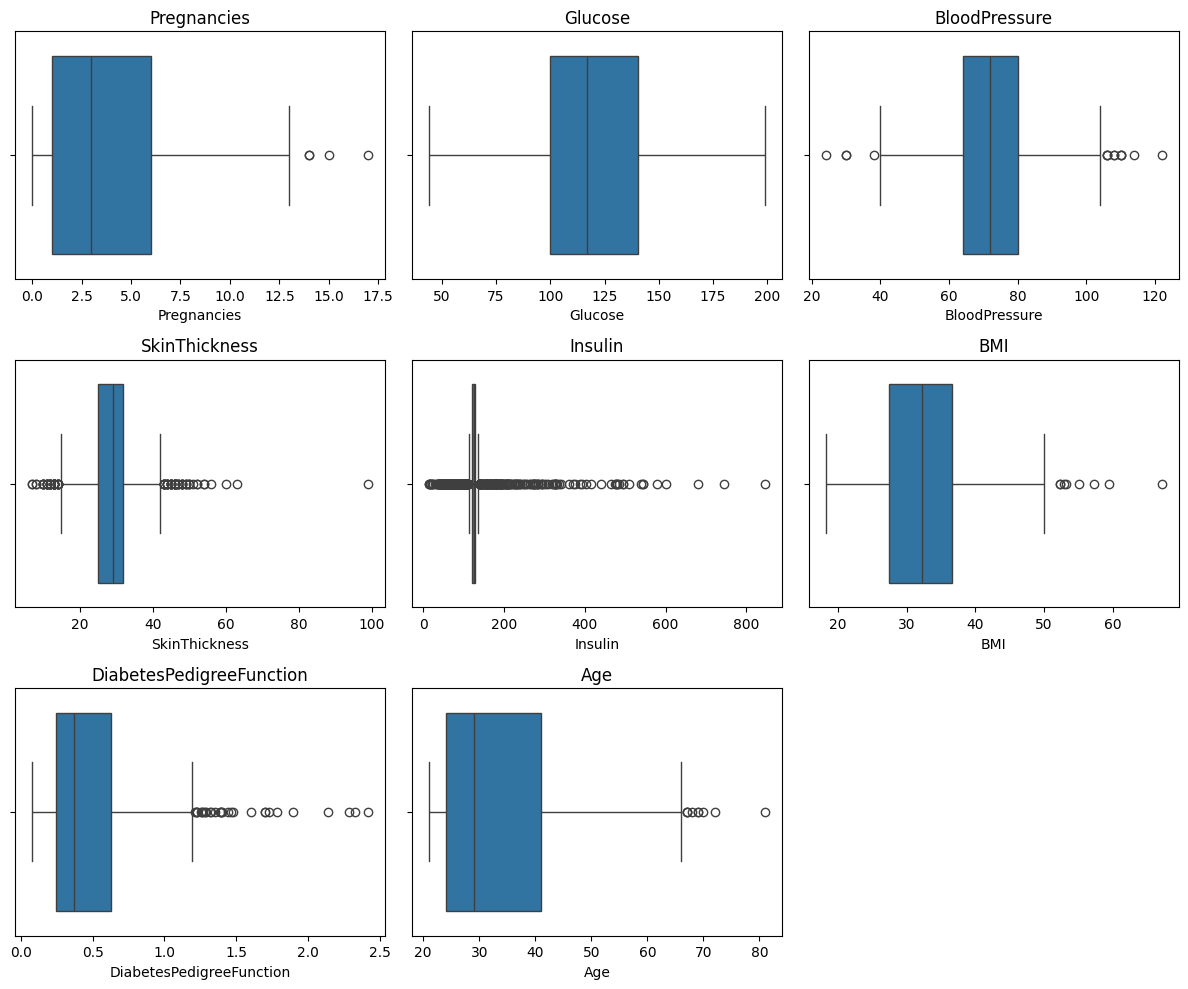

In [8]:
plt.figure(figsize=(12, 10))
for i, col in enumerate(diab.columns.drop("Outcome"), 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=diab[col])
    plt.title(col)
plt.tight_layout()
plt.show()

En el análisis de outliers se observan valores extremos en variables como Insulin, SkinThickness y BMI. Sin embargo, estos valores se consideran fisiológicamente plausibles y pertenecen a pacientes reales.
Dado que el modelo a emplear es un árbol de decisión (modelo robusto frente a outliers), no se procede a su eliminación. Los valores se mantienen íntegros para preservar la variabilidad clínica del dataset.

### Distribuciones de variables numéricas

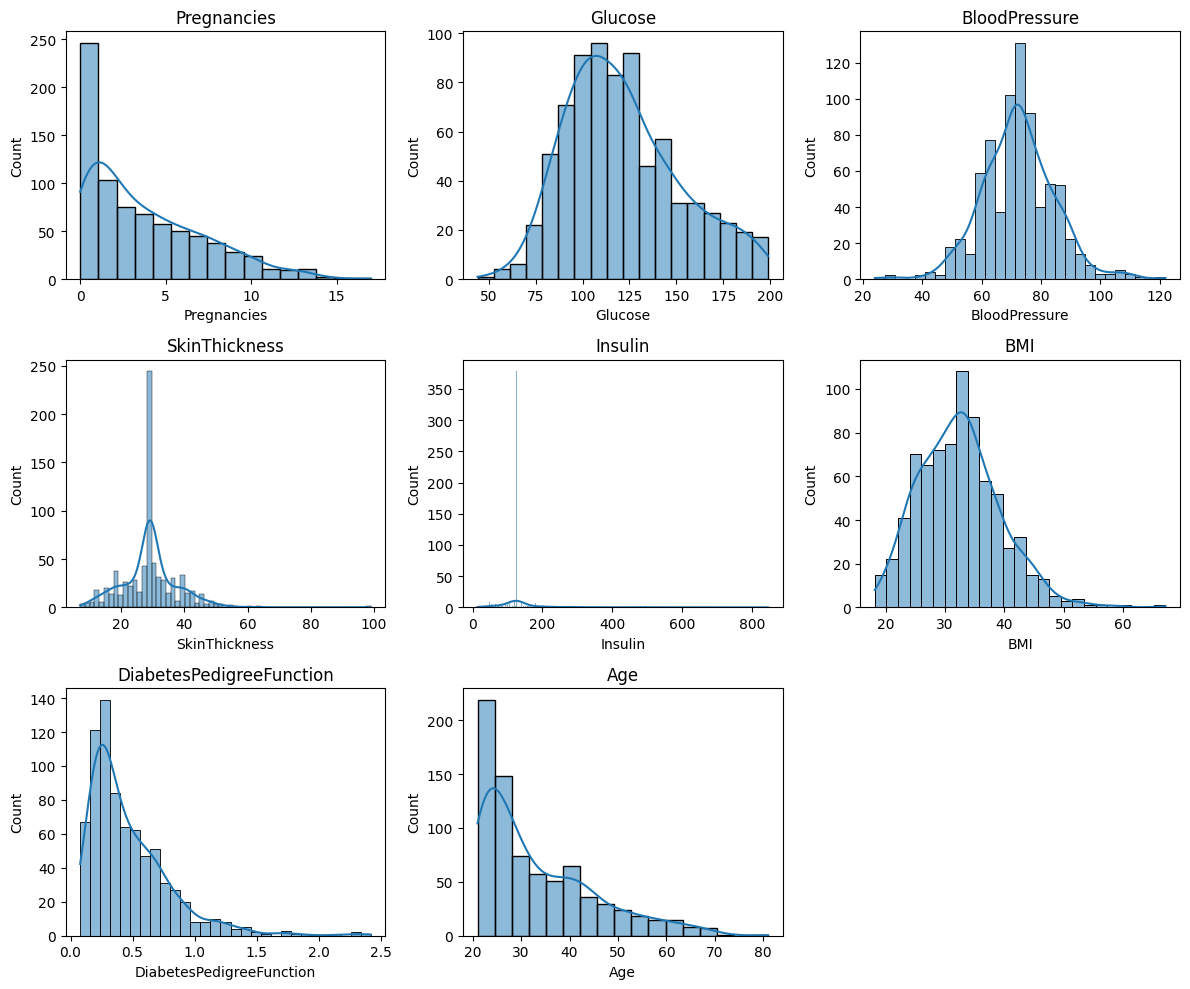

In [9]:
num_columns = diab.columns.drop("Outcome")

plt.figure(figsize=(12, 10))
for i, col in enumerate(num_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(diab[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

Las distribuciones muestran que la mayoría de las variables presentan sesgo a la derecha, especialmente Insulin, SkinThickness, BMI y DiabetesPedigreeFunction.
Se pueden observar valores 0 en variables como Glucose, BloodPressure, SkinThickness, Insulin y BMI, que representan datos faltantes.
Las distribuciones confirman que variables como Glucose, BMI y Age presentan patrones claramente distintos entre pacientes con y sin diabetes.

### Boxplots de cada variable vs Outcome

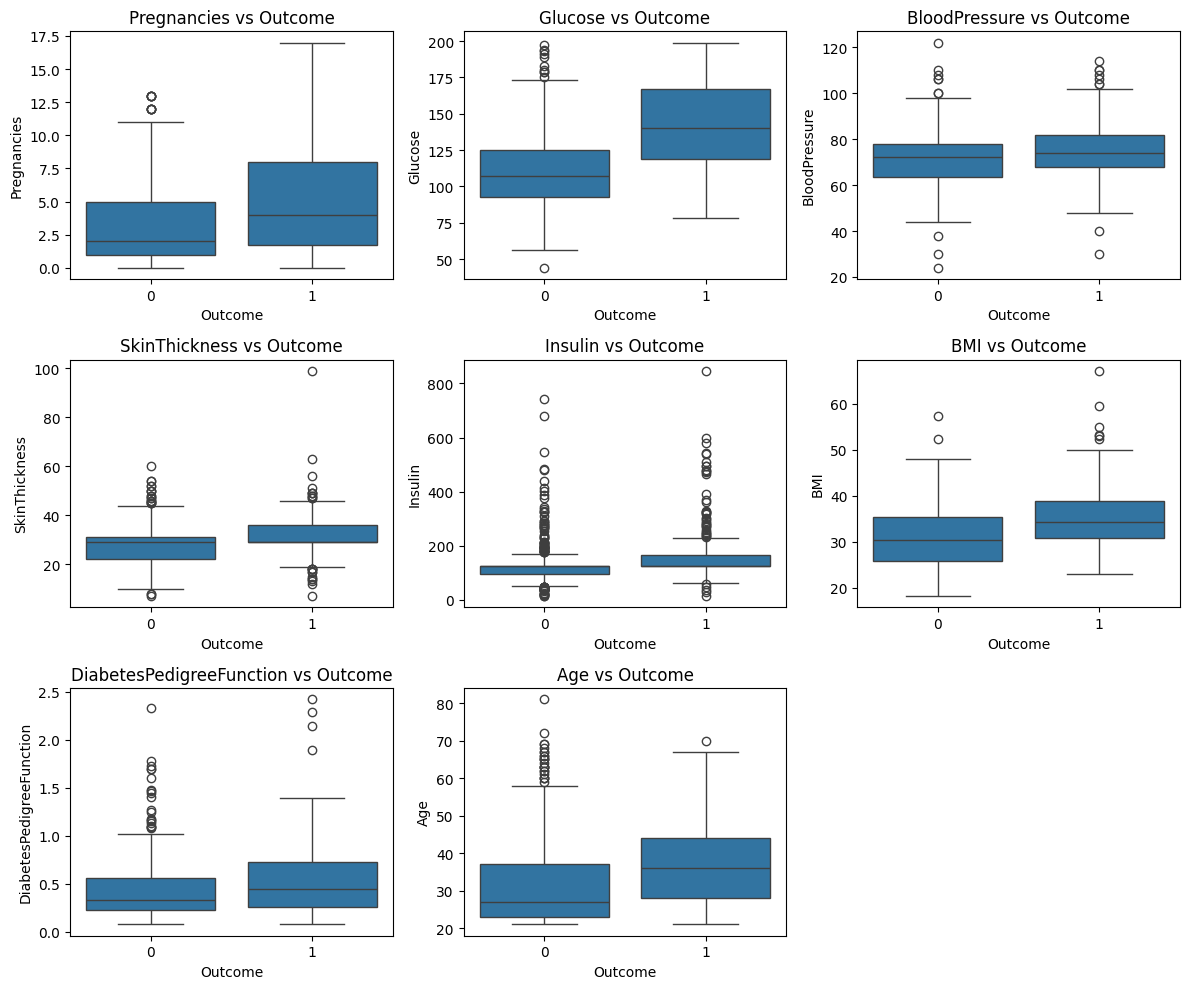

In [10]:
plt.figure(figsize=(12, 10))
for i, col in enumerate(diab.columns.drop("Outcome"), 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=diab, x="Outcome", y=col)
    plt.title(f"{col} vs Outcome")
plt.tight_layout()
plt.show()

El análisis mediante boxplots muestra diferencias claras entre las clases en variables como Glucose, BMI y Age, que presentan valores notablemente mayores en pacientes diabéticos. Estas variables son probablemente las principales responsables de la capacidad predictiva del modelo.
Por el contrario, variables como BloodPressure, SkinThickness e Insulin muestran una mayor superposición entre clases, indicando una menor utilidad individual, aunque pueden aportar información combinadas con el resto.
En conjunto, este análisis preliminar permite anticipar cuáles serán las variables más relevantes en el árbol de decisión, confirmando principalmente la importancia de Glucose.

### Matriz de correlación

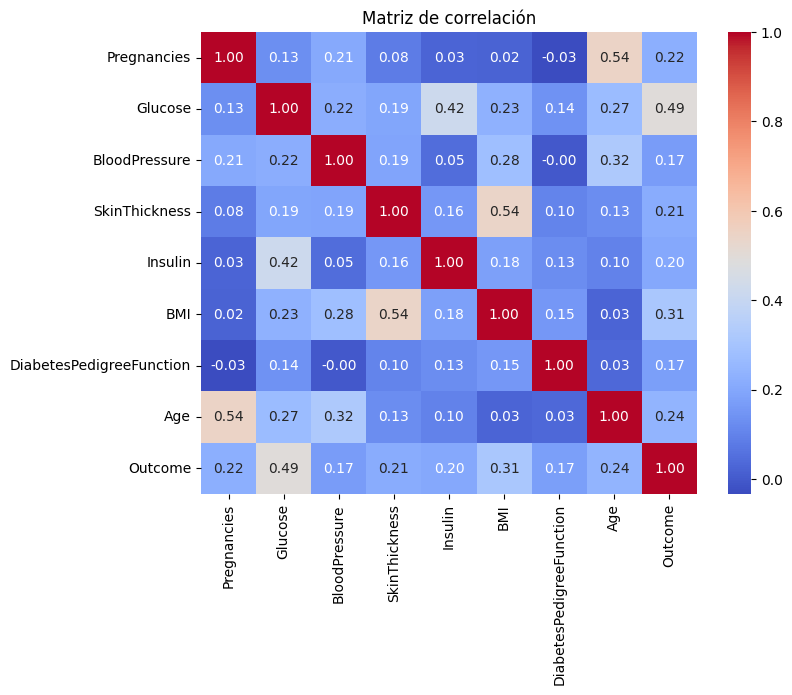

In [11]:
plt.figure(figsize=(8,6))
sns.heatmap(diab.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación")
plt.show()


La matriz de correlación revela que la variable con mayor relación con el resultado (Outcome) es Glucose, seguida de BMI, Age y Pregnancies. El resto de variables presentan correlaciones bajas con el objetivo, lo que indica que aportan menos información predictiva de forma individual.
No se observan correlaciones fuertes entre las variables independientes, lo que indica ausencia de problemas de multicolinealidad.
Estos resultados son coherentes con los boxplots del apartado anterior y confirman que Glucose, BMI y Age serán probablemente las variables más relevantes para el modelo de árbol de decisión

## Entrenamiento inicial sin transformación de características
En esta sección se entrena el modelo base, que consiste en construir un árbol de decisión utilizando el dataset original sin aplicar imputación ni transformaciones a las características.
Este paso forma parte de la version mínima del modelo, y sirve para obtener un punto de referenciaque permita comparar posteriormente el impacto de aplicar técnicas de ingeniería de características o imputación

#### Split

In [12]:
X = diab.drop("Outcome", axis=1)
y = diab["Outcome"]

#Se utiliza el parámetro stratify=y en train_test_split para garantizar que la proporción de clases (Outcome 0 y 1)
#se mantenga igual tanto en el conjunto de entrenamiento como en el de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


#### Construir train y test

In [13]:
X_train_sel = X_train.copy()
X_train_sel["Outcome"] = y_train.values

X_test_sel = X_test.copy()
X_test_sel["Outcome"] = y_test.values

X_test_sel.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
44,7,159.0,64.0,29.0,125.0,27.4,0.294,40,0
672,10,68.0,106.0,23.0,49.0,35.5,0.285,47,0
700,2,122.0,76.0,27.0,200.0,35.9,0.483,26,0
630,7,114.0,64.0,29.0,125.0,27.4,0.732,34,1
81,2,74.0,72.0,29.0,125.0,32.3,0.102,22,0


#### Guardar modelo procesado

In [14]:
X_train_sel.to_csv("../data/processed/04_diab_clean_train.csv", index=False)
X_test_sel.to_csv("../data/processed/04_diab_clean_test.csv", index=False)

#### Cargar los csv procesados

In [15]:
train_data = pd.read_csv("../data/processed/04_diab_clean_train.csv")
test_data = pd.read_csv("../data/processed/04_diab_clean_test.csv")

#### Gráfico de coordenadas paralelas

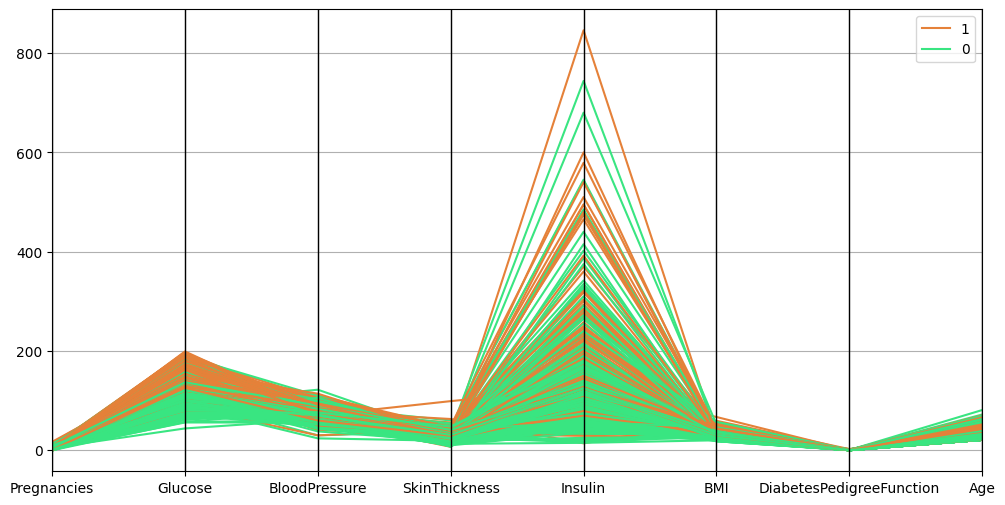

In [16]:
plt.figure(figsize=(12, 6))
pd.plotting.parallel_coordinates(diab, "Outcome", color = ("#E58139", "#39E581", "#8139E5"))
plt.show()

#### Separar para el modelo

In [17]:
X_train = train_data.drop("Outcome", axis=1)
y_train = train_data["Outcome"]

X_test = test_data.drop("Outcome", axis=1)
y_test = test_data["Outcome"]

#### Entrenar *modelo*

In [18]:
#gini, entropy, log_loss
model = DecisionTreeClassifier(criterion="gini", random_state=42)
model.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


#### Visualización árbol de decision

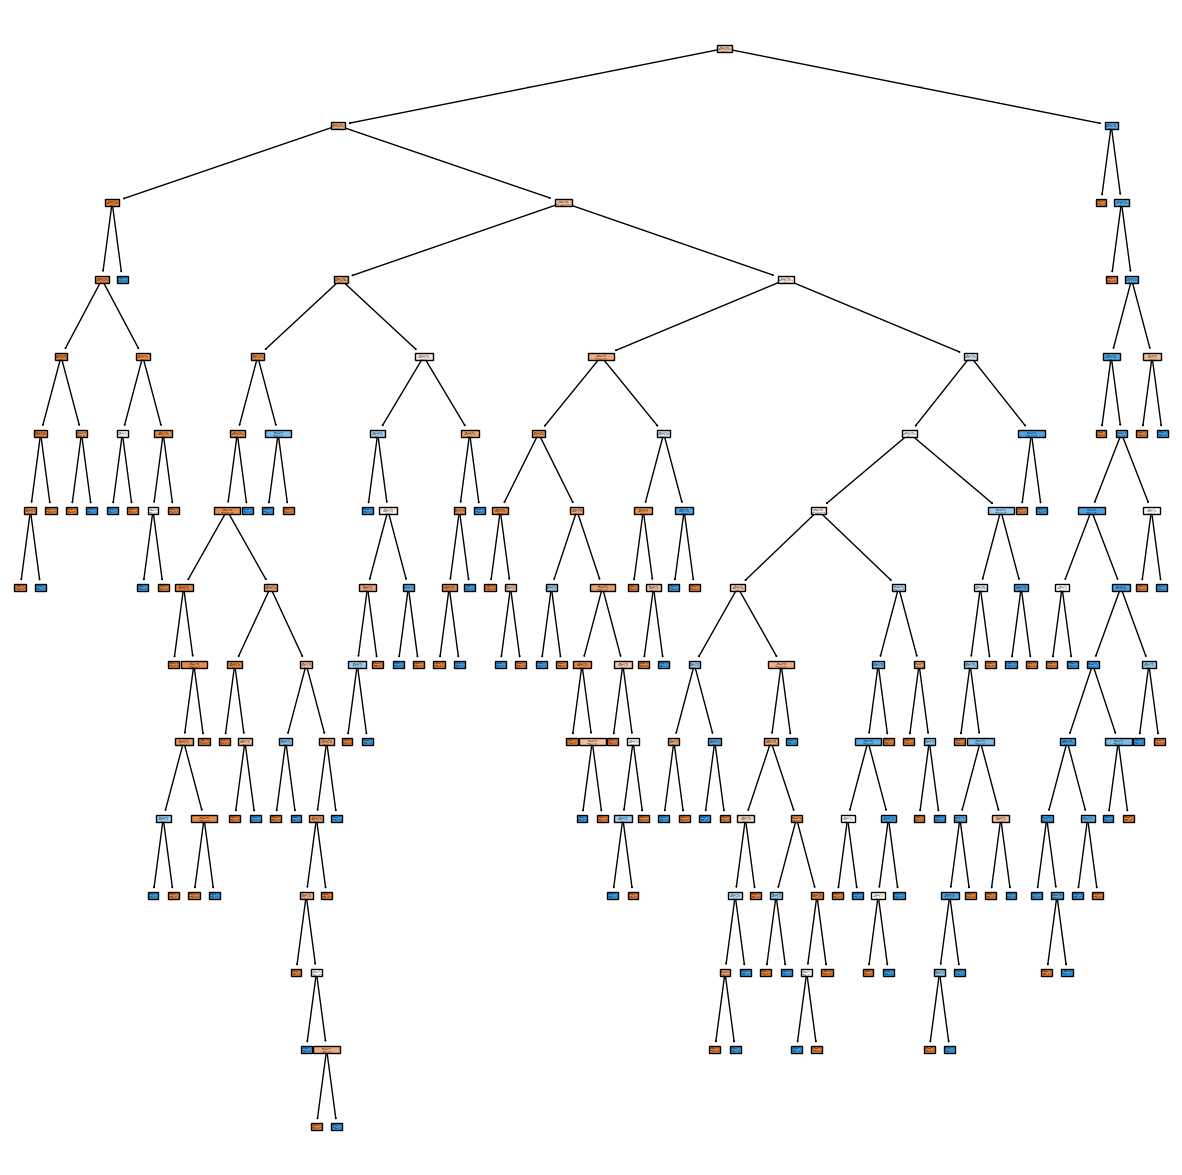

In [19]:
plt.figure(figsize=(15,15))
tree.plot_tree(
    model,
    feature_names=list(X_train.columns),
    class_names=["0", "1"],
    filled=True
)
plt.show()

#### Predicciones y accuracy

In [20]:
y_pred = model.predict(X_test)

Accuracy = accuracy_score(y_test, y_pred)
Accuracy

0.6818181818181818

#### Optimización del modelo con GridSearchCV (opc)

In [21]:
hyperparams = {"criterion": ["gini", "entropy", "log_loss"],
               "max_depth": [None, 5, 10, 20],
               "min_samples_split": [2, 5, 10],
               "min_samples_leaf": [1, 2, 4]}

#crear el GridSearch
model = DecisionTreeClassifier(random_state=42)
grid = GridSearchCV(model, hyperparams, scoring="accuracy", cv=10)
grid

,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'criterion': ['gini', 'entropy', ...], 'max_depth': [None, 5, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


#### Entrenar el GridSearch

In [22]:
grid.fit(X_train, y_train)
grid.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

Usamos los parametros encontrados en el grid para ver si mejoran los resultados


In [23]:
model = DecisionTreeClassifier(criterion="gini",
                               random_state=42,
                               max_depth=5,
                               min_samples_leaf=2,
                               min_samples_split=10)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred

array([1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0])

In [24]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7662337662337663

Se realiza una búsqueda de combinaciones de hiperparámetros mediante Grid Search.
Con los hiperparámetros óptimos obtenidos, se entrena un nuevo modelo final, que posteriormente se evalúa sobre el conjunto de test para comprobar su capacidad de generalización obteniendo unos mejores resultados.

#### Métricas

In [25]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

#matriz de confusión
mc = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(mc, index=['Real 0', 'Real 1'], columns=['Pred 0', 'Pred 1'])

metrics_df = pd.DataFrame({
    "Accuracy":  [accuracy],
    "Precision": [precision],
    "Recall":    [recall],
    "F1-score":  [f1]
})

mc, metrics_df

(array([[79, 21],
        [15, 39]]),
    Accuracy  Precision    Recall  F1-score
 0  0.766234       0.65  0.722222  0.684211)

In [26]:
#tabla comparativa
metrics_tree = metrics_df.copy()
metrics_tree.index = ["Decision Tree"]
metrics_tree.to_csv("../models/metrics_diab.csv", index=True)
metrics_tree = pd.read_csv("../models/metrics_diab.csv", index_col=0)
metrics_tree

,Accuracy,Precision,Recall,F1-score
Decision Tree,0.766234,0.65,0.722222,0.684211


Vemos que todas estas métricas son relativamente mejorables, esto puede ser debido a que hay muchos valores 0 y outliers. Vemos el recall en 70%, esto en dataset médicos no es bueno ya que mide de todas las personas que **sí** tienen diabetes, cuantas fue capaz de detectar el modelo.

In [27]:
#serailización de objetos
dump(model, open("../models/diab_tree_classifier_crit-entro_maxdepth-5_minleaf-2_minsplit10_42.sav", "wb"))